In [ ]:
# check library version numbers
import os, glob
import numpy as np
print('numpy: %s' % np.__version__)
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import random
import seaborn as sns
import skimage
import scipy
import plotly
import PIL
from PIL import Image, ImageDraw, ImageFilter
import cv2
print('opencv: %s' % cv2.__version__)
print('PIL: %s' % PIL.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

numpy: 1.25.2
matplotlib: 3.7.1
opencv: 4.8.0
PIL: 9.4.0


In [ ]:
# DL modules
# tensorflow
import tensorflow as tf
# keras
import keras
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K


In [ ]:
# standard decoder dna --> image
# generates images out of snp data
def dna2image(n_snp,image_size):
    input = tf.keras.layers.Input(shape=(n_snp))
    initializer = tf.keras.initializers.GlorotNormal()

    x = tf.keras.layers.Dense(np.prod(image_size), kernel_initializer=initializer)(input)
    x = tf.keras.layers.Reshape(image_size+(1,))(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)

    output = tf.keras.layers.Conv2DTranspose(1, (5,5), activation='relu', padding='same')(x)

    return tf.keras.Model(input, output)

In [ ]:
# generate cropped and resized images from contours
def crop(c, max_box=(225, 973, 2283, 2494), insize=(3507, 2481), outsize=(128,128), slack=20):
    imw = np.zeros(insize)
    cv2.drawContours(imw, c, -1, (255,255,255), 5)
    cv2.fillPoly(imw, [c], (255,255,255))
    # crop
    x0,y0,x1,y1 = max_box
    imw = imw[y0-slack:y1+slack, x0-slack:x1+slack]
    # resize
    #imw = cv2.resize(imw, outsize, cv2.IMREAD_UNCHANGED)
    imw = cv2.resize(imw, outsize, interpolation = cv2.INTER_AREA)
    return imw

In [ ]:
# function to plot a sample (n=5) of observed vs predicted fruits
def plot_obs_exp(dna, imgs, model, n=5):
    ilist = [10, 20, 30, 40, 50]
    image_size = imgs.shape[1:3]
    plt.figure(figsize=(15, 15))
    for i,ind in enumerate(ilist):
        ax = plt.subplot(5, 5, 1+i)
        plt.imshow(imgs[ind,])
        plt.title('Observed:'+str(ind))
        plt.axis("off")
    for i,id in enumerate(ilist):
        ax = plt.subplot(5, 5, 6+i)
        g = tf.expand_dims(dna[id,:], 0)
        img = model.predict(g).reshape(image_size)
        plt.imshow(img)
        plt.title('Predicted:'+str(id))
        plt.axis("off")

In [ ]:
 # read contours
ind_contours = pickle.load(open('TraditomContours.pkl', 'rb'))

In [ ]:
ind_contours.keys()

dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1032', '1031', '1033', '1034', '1035', '1036', '1037', '1038', '1040', '1039', '1041', '1042', '1043', '1044', '1045', '1046', '1048', '1047', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1060', '1059', '1061', '1062', '1063', '1064', '1066', '1065', '1067', '1068', '1069', '1070', '1072', '1071', '1073', '1075', '1074', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084', '1085', '1087', '1086', '1088', '1090', '1089', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1100', '1099', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1109', '1108', '1110', '1111', '1112', '1114', '1113', '1115', '1116', '1117', '1118', '1119', '1121', '1120', 'MS_1', 'MS_2

In [ ]:
# # total no. images
n=0
for _ in ind_contours:
    n+=len(ind_contours[_])
n

353

In [ ]:
# read pedigree
ped = pd.read_csv('TraditomPedigree.txt', sep='\t')

# how many parental and maternal lines
print('N females',len(pd.unique(ped['Female']))-1)
print('N males',len(pd.unique(ped['Male']))-1)

N females 25
N males 7


In [ ]:
ped.head()

,Ind,Female,Male
0,1000,0,0
1,1001,1000,MS_1
2,1002,1000,MS_2
3,1003,1000,MS_3
4,1004,1000,MS_4


In [ ]:
# read 'causative' QTNs (tomato anayzer metrics)
qtn = pd.read_csv('TraditomGpred.txt', header=None, sep=' ')

# read GBS genotypes in ped order
gbs = np.array(pd.read_csv('TraditomGBS.txt', header=None, sep=' '))

# first col is individual
n_snp = qtn.shape[1]-1 + gbs.shape[1]


In [ ]:
# generate qtn + imgset,
image_size = (128,128)
dnaset = []
imgset1 = []
for i,ind in enumerate(ped['Ind']):
    # skip first column
    q = np.array(qtn.loc[qtn[0]==ind])[0,1:]
    # gbs
    q = np.concatenate((q,gbs[i,:]),axis=0)
    for ci in ind_contours[ind]:
        dnaset.append(q)
        imgset1.append(crop(ci))

dnaset = np.asarray(dnaset, dtype='float32')
imgset1 = np.asarray(imgset1, dtype='float32')
n_snp = dnaset.shape[1]


In [ ]:
# split data
dna_train, dna_val, imgs_train, imgs_val = train_test_split(dnaset, imgset1, test_size=0.2)


In [ ]:
dna_train_new, dna_val_new, imgs_train_new, imgs_val_new = train_test_split(dnaset, imgset1, test_size=0.1)


In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_20 = dna2image(n_snp,image_size)

decoder_20.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_20.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1916928   
                                                                 
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 128, 128, 16)      160       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 8)       1160      
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 1)       201   

In [ ]:
epochs = 20

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_20.fit(x=dna_train,
            y=imgs_train,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/20
24/24 [==============================] - 11s 397ms/step - loss: 8418.5713 - mean_squared_error: 8418.5713 - val_loss: 5673.7939 - val_mean_squared_error: 5673.7939
Epoch 2/20
24/24 [==============================] - 9s 362ms/step - loss: 3603.8074 - mean_squared_error: 3603.8074 - val_loss: 2167.9497 - val_mean_squared_error: 2167.9500
Epoch 3/20
24/24 [==============================] - 10s 412ms/step - loss: 1916.6666 - mean_squared_error: 1916.6666 - val_loss: 1251.1993 - val_mean_squared_error: 1251.1993
Epoch 4/20
24/24 [==============================] - 10s 417ms/step - loss: 1417.5688 - mean_squared_error: 1417.5688 - val_loss: 1068.6882 - val_mean_squared_error: 1068.6882
Epoch 5/20
24/24 [==============================] - 9s 360ms/step - loss: 1265.6213 - mean_squared_error: 1265.6213 - val_loss: 980.0030 - val_mean_squared_error: 980.0030
Epoch 6/20
24/24 [==============================] - 9s 355ms/step - loss: 1181.1072 - mean_squared_error: 1181.1072 - val_loss: 9

In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_20_new = dna2image(n_snp,image_size)

decoder_20_new.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_20_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             1916928   
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 16)      160       
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 128, 128, 8)       1160      
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 128, 128, 1)       201 

In [ ]:
epochs = 20

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_20_new.fit(x=dna_train_new,
            y=imgs_train_new,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val_new,imgs_val_new),)

Epoch 1/20
27/27 [==============================] - 11s 365ms/step - loss: 8488.2109 - mean_squared_error: 8488.2100 - val_loss: 5901.3408 - val_mean_squared_error: 5901.3408
Epoch 2/20
27/27 [==============================] - 8s 314ms/step - loss: 3248.0117 - mean_squared_error: 3248.0117 - val_loss: 2179.1716 - val_mean_squared_error: 2179.1716
Epoch 3/20
27/27 [==============================] - 9s 345ms/step - loss: 1517.8304 - mean_squared_error: 1517.8304 - val_loss: 1618.4623 - val_mean_squared_error: 1618.4623
Epoch 4/20
27/27 [==============================] - 9s 352ms/step - loss: 1235.0653 - mean_squared_error: 1235.0653 - val_loss: 1411.6862 - val_mean_squared_error: 1411.6862
Epoch 5/20
27/27 [==============================] - 8s 303ms/step - loss: 1143.4316 - mean_squared_error: 1143.4316 - val_loss: 1364.0139 - val_mean_squared_error: 1364.0139
Epoch 6/20
27/27 [==============================] - 9s 352ms/step - loss: 1093.1350 - mean_squared_error: 1093.1350 - val_loss: 1

In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_40 = dna2image(n_snp,image_size)

decoder_40.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_40.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             1916928   
                                                                 
 reshape_2 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 128, 128, 16)      160       
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 128, 128, 8)       1160      
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 128, 128, 1)       201 

In [ ]:
epochs = 40

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_40.fit(x=dna_train,
            y=imgs_train,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/40
24/24 [==============================] - 11s 424ms/step - loss: 8492.3105 - mean_squared_error: 8492.3105 - val_loss: 5970.4038 - val_mean_squared_error: 5970.4038
Epoch 2/40
24/24 [==============================] - 9s 358ms/step - loss: 3440.0198 - mean_squared_error: 3440.0198 - val_loss: 1761.6360 - val_mean_squared_error: 1761.6360
Epoch 3/40
24/24 [==============================] - 8s 316ms/step - loss: 1539.7903 - mean_squared_error: 1539.7903 - val_loss: 1186.3473 - val_mean_squared_error: 1186.3473
Epoch 4/40
24/24 [==============================] - 9s 372ms/step - loss: 1252.2166 - mean_squared_error: 1252.2166 - val_loss: 998.1011 - val_mean_squared_error: 998.1011
Epoch 5/40
24/24 [==============================] - 9s 367ms/step - loss: 1180.3936 - mean_squared_error: 1180.3936 - val_loss: 969.6221 - val_mean_squared_error: 969.6221
Epoch 6/40
24/24 [==============================] - 8s 327ms/step - loss: 1132.0176 - mean_squared_error: 1132.0176 - val_loss: 933.2

In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_30 = dna2image(n_snp,image_size)

decoder_30.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_30.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense_3 (Dense)             (None, 16384)             1916928   
                                                                 
 reshape_3 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 128, 128, 16)      160       
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 128, 128, 8)       1160      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 128, 128, 1)       201 

In [ ]:
epochs = 30

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_30.fit(x=dna_train,
            y=imgs_train,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/30
24/24 [==============================] - 10s 345ms/step - loss: 8523.7373 - mean_squared_error: 8523.7373 - val_loss: 5806.4395 - val_mean_squared_error: 5806.4395
Epoch 2/30
24/24 [==============================] - 9s 369ms/step - loss: 3755.9436 - mean_squared_error: 3755.9436 - val_loss: 2354.9165 - val_mean_squared_error: 2354.9165
Epoch 3/30
24/24 [==============================] - 8s 346ms/step - loss: 1958.8198 - mean_squared_error: 1958.8198 - val_loss: 1290.3562 - val_mean_squared_error: 1290.3563
Epoch 4/30
24/24 [==============================] - 8s 332ms/step - loss: 1418.0825 - mean_squared_error: 1418.0825 - val_loss: 1061.2148 - val_mean_squared_error: 1061.2148
Epoch 5/30
24/24 [==============================] - 9s 372ms/step - loss: 1265.2290 - mean_squared_error: 1265.2290 - val_loss: 992.6241 - val_mean_squared_error: 992.6241
Epoch 6/30
24/24 [==============================] - 8s 345ms/step - loss: 1193.1376 - mean_squared_error: 1193.1376 - val_loss: 969

# **observed vs predicted without colour vs highlighted prediction**





In [ ]:
def plot_obs_exp_with_highlight(dna, imgs, model, n=5, highlight_alpha=0.3):
    ilist = np.random.randint(0, dna.shape[0], n) # make fixed values
    image_size = imgs.shape[1:3]
    plt.figure(figsize=(15, 15))
    for i, ind in enumerate(ilist):
        ax = plt.subplot(5, 5, 1+i)
        plt.imshow(imgs[ind,], cmap='gray')  # Observed without color
        plt.title('Observed:'+str(ind))
        plt.axis("off")
    for i, id in enumerate(ilist):
        ax = plt.subplot(5, 5, 6+i)
        g = tf.expand_dims(dna[id, :], 0)
        img = model.predict(g).reshape(image_size)
        plt.imshow(img, cmap='gray')  # Predicted without color
        plt.title('Predicted:'+str(id))
        plt.axis("off")
        # Highlight predicted area
        ax.imshow(img, cmap='viridis', alpha=highlight_alpha)  # Highlighted prediction


In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_50 = dna2image(n_snp,image_size)

decoder_50.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_50.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense_4 (Dense)             (None, 16384)             1916928   
                                                                 
 reshape_4 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 128, 128, 16)      160       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 128, 128, 8)       1160      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 128, 128, 1)       201 

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
import visualkeras


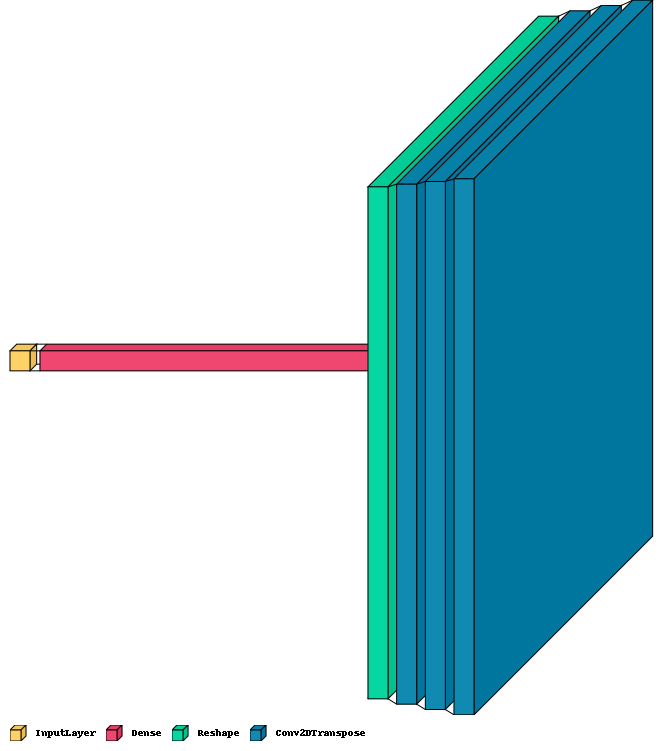

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import visualkeras

input_layer = Input(shape=(116,), name='input_1')
dense_layer = Dense(16384, name='dense_1')(input_layer)
reshape_layer = Reshape((128, 128, 1), name='reshape_1')(dense_layer)
conv_transpose_1 = Conv2DTranspose(16, kernel_size=(3, 3), name='conv2d_transpose_1')(reshape_layer)
conv_transpose_2 = Conv2DTranspose(8, kernel_size=(3, 3), name='conv2d_transpose_2')(conv_transpose_1)
conv_transpose_3 = Conv2DTranspose(1, kernel_size=(3, 3), name='conv2d_transpose_3')(conv_transpose_2)

model = Model(inputs=input_layer, outputs=conv_transpose_3, name='decoder_20')

visualkeras.layered_view(model, legend=True)


In [ ]:
epochs = 50

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_50.fit(x=dna_train,
            y=imgs_train,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/50
24/24 [==============================] - 22s 882ms/step - loss: 8440.8125 - mean_squared_error: 8440.8125 - val_loss: 5961.2012 - val_mean_squared_error: 5961.2012
Epoch 2/50
24/24 [==============================] - 18s 746ms/step - loss: 3723.5483 - mean_squared_error: 3723.5483 - val_loss: 2261.2288 - val_mean_squared_error: 2261.2288
Epoch 3/50
24/24 [==============================] - 11s 437ms/step - loss: 1762.0131 - mean_squared_error: 1762.0131 - val_loss: 1363.4169 - val_mean_squared_error: 1363.4169
Epoch 4/50
24/24 [==============================] - 9s 362ms/step - loss: 1338.5029 - mean_squared_error: 1338.5029 - val_loss: 1109.6373 - val_mean_squared_error: 1109.6373
Epoch 5/50
24/24 [==============================] - 7s 312ms/step - loss: 1207.7292 - mean_squared_error: 1207.7292 - val_loss: 1056.9142 - val_mean_squared_error: 1056.9143
Epoch 6/50
24/24 [==============================] - 9s 362ms/step - loss: 1163.8291 - mean_squared_error: 1163.8291 - val_loss:

In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_60 = dna2image(n_snp,image_size)

decoder_60.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_60.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 116)]             0         
                                                                 
 dense_5 (Dense)             (None, 16384)             1916928   
                                                                 
 reshape_5 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 128, 128, 16)      160       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_16 (Conv2  (None, 128, 128, 8)       1160      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 128, 128, 1)       201 

In [ ]:
epochs = 60

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_60.fit(x=dna_train,
            y=imgs_train,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

Epoch 1/60
24/24 [==============================] - 17s 652ms/step - loss: 8412.4961 - mean_squared_error: 8412.4961 - val_loss: 5927.9741 - val_mean_squared_error: 5927.9741
Epoch 2/60
24/24 [==============================] - 17s 717ms/step - loss: 3614.9353 - mean_squared_error: 3614.9353 - val_loss: 2243.9944 - val_mean_squared_error: 2243.9944
Epoch 3/60
24/24 [==============================] - 10s 372ms/step - loss: 1891.4714 - mean_squared_error: 1891.4714 - val_loss: 1351.5215 - val_mean_squared_error: 1351.5215
Epoch 4/60
24/24 [==============================] - 9s 361ms/step - loss: 1447.0616 - mean_squared_error: 1447.0616 - val_loss: 1111.5225 - val_mean_squared_error: 1111.5225
Epoch 5/60
24/24 [==============================] - 7s 310ms/step - loss: 1290.3595 - mean_squared_error: 1290.3595 - val_loss: 1038.5171 - val_mean_squared_error: 1038.5171
Epoch 6/60
24/24 [==============================] - 9s 349ms/step - loss: 1226.7894 - mean_squared_error: 1226.7894 - val_loss:

In [ ]:
predicted_images_20_epochs = decoder_20.predict(dna_val)
predicted_images_20_epochs = np.squeeze(predicted_images_20_epochs)
squared_errors_20_epochs = np.square(predicted_images_20_epochs - imgs_val)
mean_squared_error_20_epochs = np.mean(squared_errors_20_epochs)
rmse_score_20_epochs = np.sqrt(mean_squared_error_20_epochs)

print("RMSE Score for Decoder trained for 20 epochs:", rmse_score_20_epochs)

predicted_images_30_epochs = decoder_30.predict(dna_val)
predicted_images_30_epochs = np.squeeze(predicted_images_30_epochs)
squared_errors_30_epochs = np.square(predicted_images_30_epochs - imgs_val)
mean_squared_error_30_epochs = np.mean(squared_errors_30_epochs)
rmse_score_30_epochs = np.sqrt(mean_squared_error_30_epochs)

print("RMSE Score for Decoder trained for 30 epochs:", rmse_score_30_epochs)

predicted_images_40_epochs = decoder_40.predict(dna_val)
predicted_images_40_epochs = np.squeeze(predicted_images_40_epochs)
squared_errors_40_epochs = np.square(predicted_images_40_epochs - imgs_val)
mean_squared_error_40_epochs = np.mean(squared_errors_40_epochs)
rmse_score_40_epochs = np.sqrt(mean_squared_error_40_epochs)

print("RMSE Score for Decoder trained for 40 epochs:", rmse_score_40_epochs)
predicted_images_50_epochs = decoder_50.predict(dna_val)
predicted_images_50_epochs = np.squeeze(predicted_images_50_epochs)
squared_errors_50_epochs = np.square(predicted_images_50_epochs - imgs_val)
mean_squared_error_50_epochs = np.mean(squared_errors_50_epochs)
rmse_score_50_epochs = np.sqrt(mean_squared_error_50_epochs)

print("RMSE Score for Decoder trained for 50 epochs:", rmse_score_50_epochs)

predicted_images_60_epochs = decoder_60.predict(dna_val)
predicted_images_60_epochs = np.squeeze(predicted_images_60_epochs)
squared_errors_60_epochs = np.square(predicted_images_60_epochs - imgs_val)
mean_squared_error_60_epochs = np.mean(squared_errors_60_epochs)
rmse_score_60_epochs = np.sqrt(mean_squared_error_60_epochs)

print("RMSE Score for Decoder trained for 60 epochs:", rmse_score_60_epochs)


3/3 [==============================] - 1s 164ms/step
RMSE Score for Decoder trained for 20 epochs: 29.25602
3/3 [==============================] - 1s 169ms/step
RMSE Score for Decoder trained for 30 epochs: 29.031206
3/3 [==============================] - 1s 166ms/step
RMSE Score for Decoder trained for 40 epochs: 29.191172
3/3 [==============================] - 1s 160ms/step
RMSE Score for Decoder trained for 50 epochs: 29.163065


3/3 [==============================] - 1s 234ms/step
RMSE Score for Decoder trained for 60 epochs: 29.654144


In [ ]:
predicted_images_20_epochs = decoder_20.predict(dna_val)
predicted_images_20_epochs = np.squeeze(predicted_images_20_epochs)
squared_errors_20_epochs = np.square(predicted_images_20_epochs - imgs_val)
mean_squared_error_20_epochs = np.mean(squared_errors_20_epochs)
rmse_score_20_epochs = np.sqrt(mean_squared_error_20_epochs)

print("RMSE Score for Decoder trained for 20 epochs:", rmse_score_20_epochs)



predicted_images_20_epochs_new = decoder_20_new.predict(dna_val_new)
predicted_images_20_epochs_new = np.squeeze(predicted_images_20_epochs_new)
squared_errors_20_epochs_new = np.square(predicted_images_20_epochs_new - imgs_val_new)
mean_squared_error_20_epochs_new = np.mean(squared_errors_20_epochs_new)
rmse_score_20_epochs_new = np.sqrt(mean_squared_error_20_epochs_new)

print("RMSE Score for Decoder trained for 20 epochs new :", rmse_score_20_epochs_new)

3/3 [==============================] - 1s 293ms/step
RMSE Score for Decoder trained for 20 epochs: 29.25602
2/2 [==============================] - 0s 48ms/step
RMSE Score for Decoder trained for 20 epochs new : 34.870808


In [ ]:
mae_20_epochs = np.mean(np.abs(predicted_images_20_epochs - imgs_val))
mae_30_epochs = np.mean(np.abs(predicted_images_30_epochs - imgs_val))
mae_40_epochs = np.mean(np.abs(predicted_images_40_epochs - imgs_val))
mae_50_epochs = np.mean(np.abs(predicted_images_50_epochs - imgs_val))
mae_60_epochs = np.mean(np.abs(predicted_images_60_epochs - imgs_val))

print("MAE for Decoder trained for 20 epochs:", mae_20_epochs)
print("MAE for Decoder trained for 30 epochs:", mae_30_epochs)
print("MAE for Decoder trained for 40 epochs:", mae_40_epochs)
print("MAE for Decoder trained for 50 epochs:", mae_50_epochs)
print("MAE for Decoder trained for 60 epochs:", mae_60_epochs)


MAE for Decoder trained for 20 epochs: 9.248272
MAE for Decoder trained for 30 epochs: 9.093867
MAE for Decoder trained for 40 epochs: 8.80498
MAE for Decoder trained for 50 epochs: 9.467902
MAE for Decoder trained for 60 epochs: 9.81619


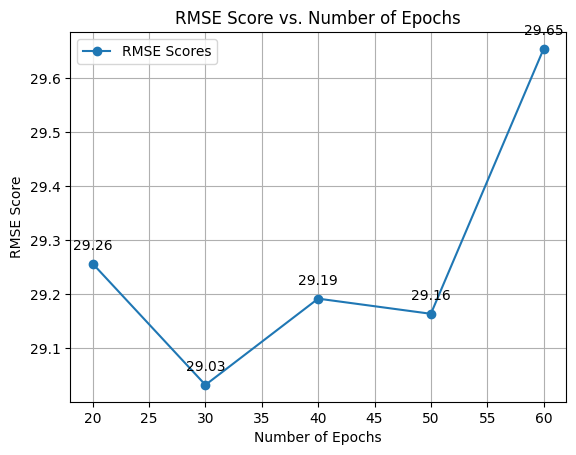

In [ ]:
import matplotlib.pyplot as plt

epochs = [20, 30, 40, 50, 60]
rmse_scores = [rmse_score_20_epochs, rmse_score_30_epochs, rmse_score_40_epochs, rmse_score_50_epochs, rmse_score_60_epochs]

plt.plot(epochs, rmse_scores, marker='o', label='RMSE Scores')
for i, txt in enumerate(rmse_scores):
    plt.annotate(round(txt, 2), (epochs[i], rmse_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('RMSE Score vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE Score')
plt.grid(True)
plt.legend()
plt.show()



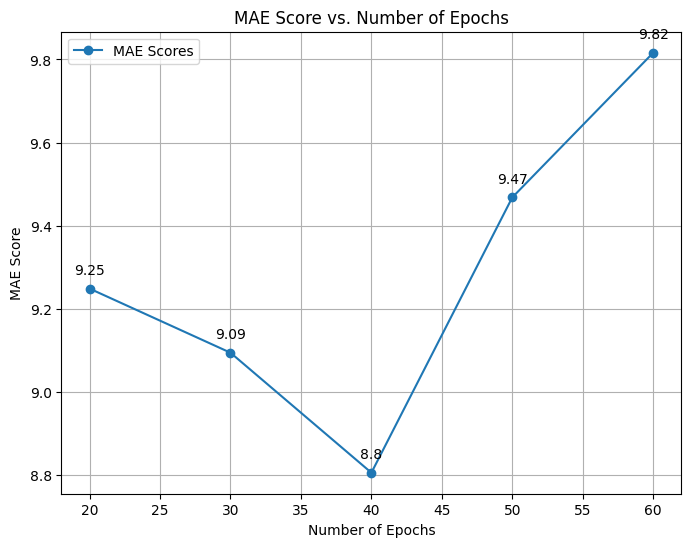

In [ ]:
import matplotlib.pyplot as plt

mae_scores = [mae_20_epochs, mae_30_epochs, mae_40_epochs, mae_50_epochs, mae_60_epochs]
epochs = [20, 30, 40, 50, 60]

# Plot RMSE scores
plt.figure(figsize=(8, 6))
plt.plot(epochs, mae_scores, marker='o', label='MAE Scores')
for i, txt in enumerate(mae_scores):
    plt.annotate(round(txt, 2), (epochs[i], mae_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('MAE Score vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('MAE Score')
plt.grid(True)
plt.legend()
plt.show()


1/1 [==============================] - 0s 39ms/step


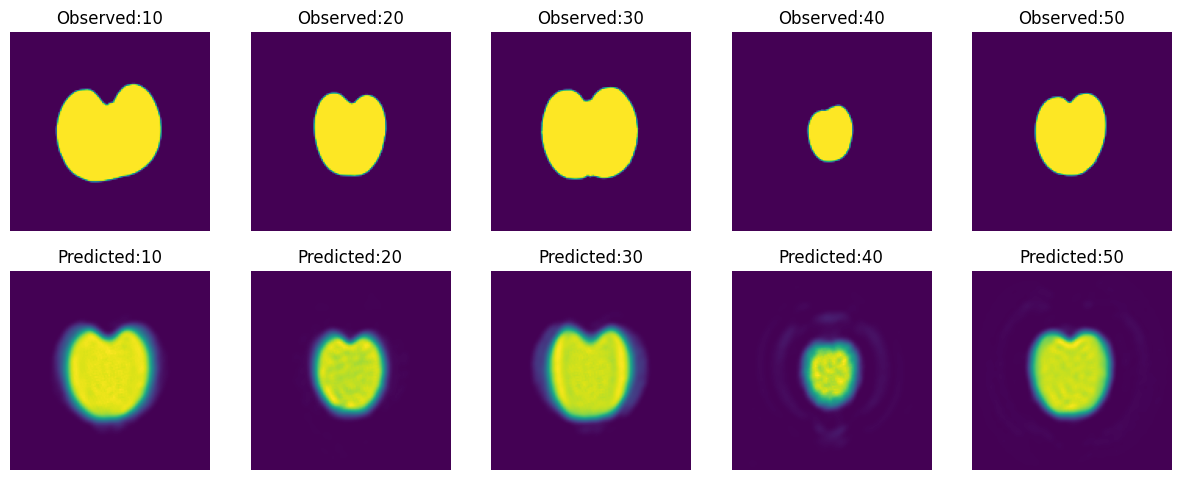

In [ ]:
plot_obs_exp(dna_val, imgs_val, decoder_20)


1/1 [==============================] - 0s 42ms/step


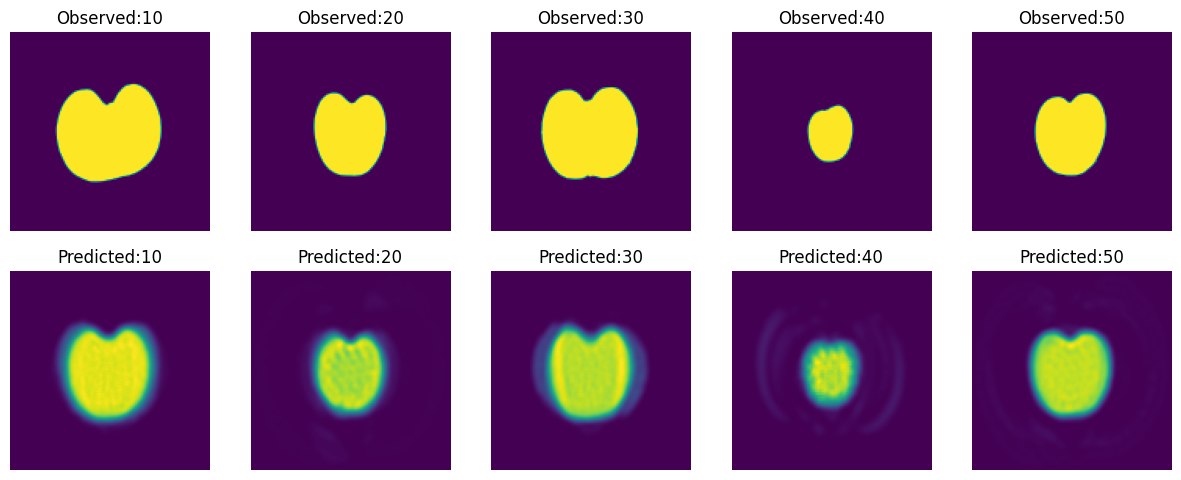

In [ ]:
plot_obs_exp(dna_val, imgs_val, decoder_30)


1/1 [==============================] - 0s 32ms/step


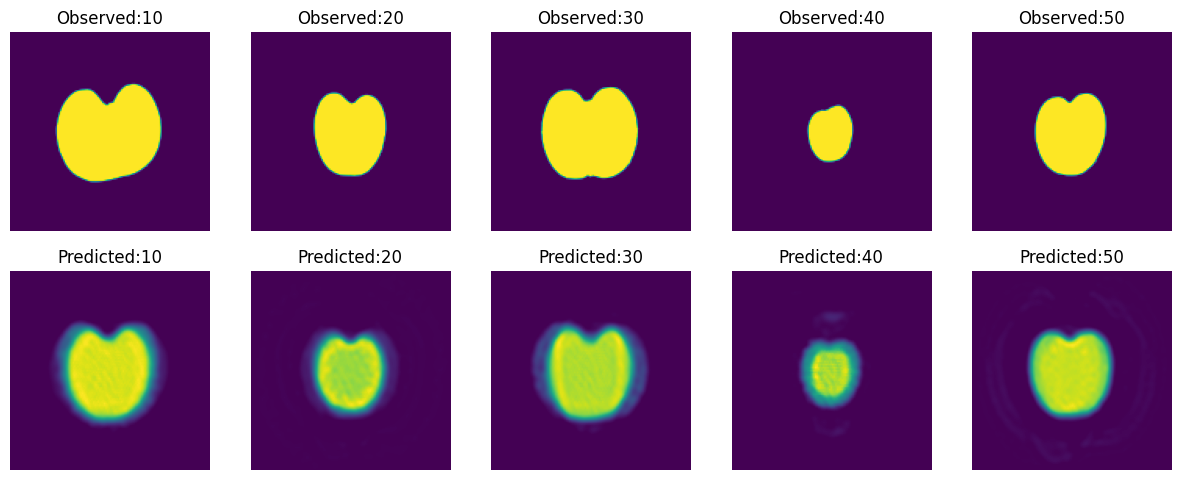

In [ ]:
plot_obs_exp(dna_val, imgs_val, decoder_40)


1/1 [==============================] - 0s 36ms/step


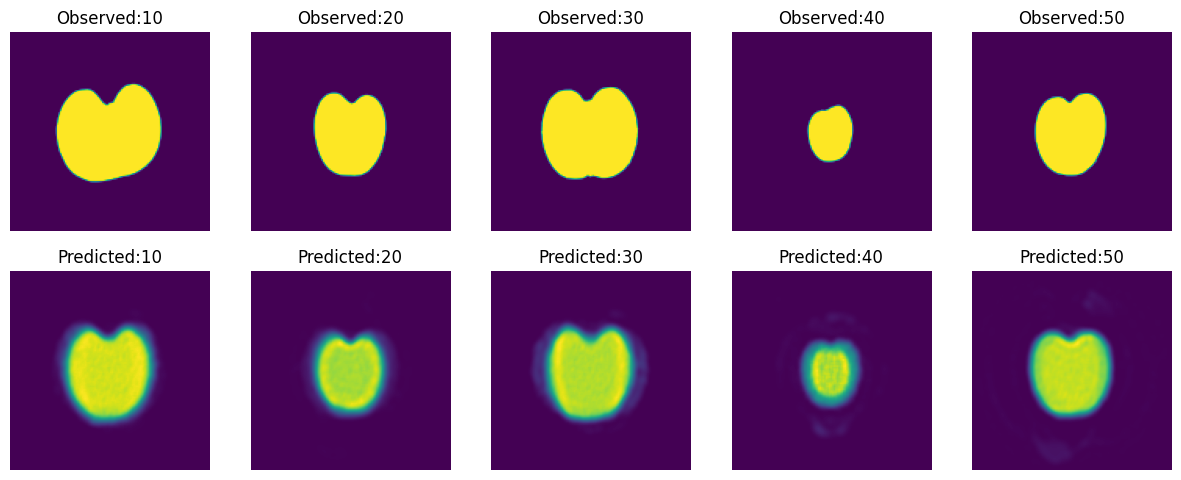

In [ ]:
plot_obs_exp(dna_val, imgs_val, decoder_50)


1/1 [==============================] - 0s 38ms/step


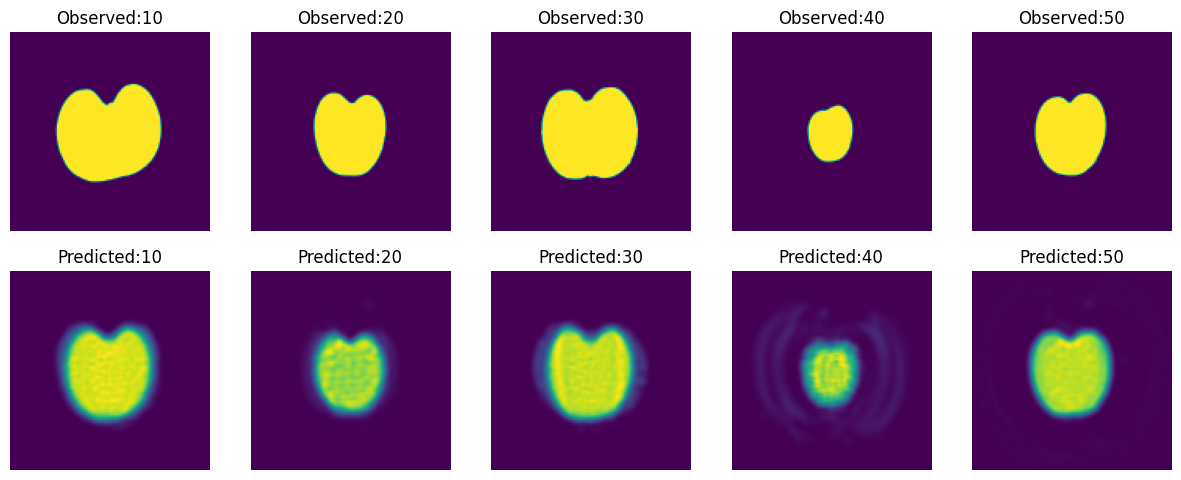

In [ ]:
 plot_obs_exp(dna_val, imgs_val, decoder_60, n=5)


In [ ]:
def generate_random_array():
    return [[[random.randint(1000, 1500), random.randint(1300, 1400)]] for _ in range(10)]

keys = ['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011',
        '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
        '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1032', '1031', '1033', '1034', '1035',
        '1036', '1037', '1038', '1040', '1039', '1041', '1042', '1043', '1044', '1045', '1046', '1048',
        '1047', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1060',
        '1059', '1061', '1062', '1063', '1064', '1066', '1065', '1067', '1068', '1069', '1070', '1072',
        '1071', '1073', '1075', '1074', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083',
        '1084', '1085', '1087', '1086', '1088', '1090', '1089', '1091', '1092', '1093', '1094', '1095',
        '1096', '1097', '1098', '1100', '1099', '1101', '1102', '1103', '1104', '1105', '1106', '1107',
        '1109', '1108', '1110', '1111', '1112', '1114', '1113', '1115', '1116', '1117', '1118', '1119',
        '1121', '1120', 'MS_1', 'MS_2', 'MS_3', 'MS_4', 'MS_5', 'MS_6', 'MS_7']

random_dictionary = {}

for key in keys:
    if key.startswith('MS_'):
        random_dictionary[key] = [generate_random_array() for _ in range(2)]
    else:
        random_dictionary[key] = random.randint(1, 100)

print(random_dictionary)






{'1000': 31, '1001': 47, '1002': 48, '1003': 83, '1004': 98, '1005': 39, '1006': 74, '1007': 31, '1008': 88, '1009': 94, '1010': 59, '1011': 77, '1012': 53, '1013': 62, '1014': 99, '1015': 21, '1016': 12, '1017': 80, '1018': 83, '1019': 54, '1020': 69, '1021': 63, '1022': 95, '1023': 36, '1024': 67, '1025': 26, '1026': 41, '1027': 95, '1028': 18, '1029': 90, '1030': 88, '1032': 54, '1031': 94, '1033': 5, '1034': 8, '1035': 26, '1036': 69, '1037': 45, '1038': 47, '1040': 17, '1039': 20, '1041': 33, '1042': 14, '1043': 65, '1044': 33, '1045': 52, '1046': 22, '1048': 35, '1047': 93, '1049': 98, '1050': 37, '1051': 42, '1052': 44, '1053': 8, '1054': 67, '1055': 17, '1056': 47, '1057': 48, '1058': 20, '1060': 64, '1059': 13, '1061': 80, '1062': 88, '1063': 40, '1064': 44, '1066': 83, '1065': 19, '1067': 95, '1068': 50, '1069': 97, '1070': 20, '1072': 9, '1071': 44, '1073': 28, '1075': 81, '1074': 90, '1076': 61, '1077': 53, '1078': 28, '1079': 21, '1080': 6, '1081': 92, '1082': 61, '1083': 

In [ ]:
def generate_ped_2(rows=5):
    data = {
        'Ind': range(1000, 1000 + rows),
        'Female': [random.randint(0, 1000) for _ in range(rows)],
        'Male': [random.choice([0, 'MS_' + str(i)]) for i in range(1, rows + 1)]
    }

    ped_2 = pd.DataFrame(data)
    ped_2['Ind'] = ped_2['Ind'].astype(str)

    return ped_2





In [ ]:
def generate_qtn_2(rows=5, columns=49):
    data = {
        'Ind': range(1000, 1000 + rows)
    }
    for i in range(1, columns):
        data[i] = np.random.randn(rows)

    qtn_2 = pd.DataFrame(data)
    return qtn_2



In [ ]:
import random
import pickle

def generate_contours(num_contours=3, num_points=10):
    return [ [[random.randint(1300, 1600), random.randint(1500, 1600)]
               for _ in range(num_points)] for _ in range(num_contours) ]

keys = [str(i) for i in range(1000, 1121)] + ['MS_{}'.format(i) for i in range(1, 8)]
ind_contours = {key: generate_contours() for key in keys}

with open('TraditomContours.pkl', 'wb') as handle:
    pickle.dump(ind_contours, handle, protocol=pickle.HIGHEST_PROTOCOL)

loaded_contours = pickle.load(open('TraditomContours.pkl', 'rb'))
print(list(loaded_contours.keys()))


['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112', '1113', '1114', '1115', '1116', '1117', '1118', '1119', '1120', 'MS_1', 'MS_2', 'MS_3', 'MS_4',

In [ ]:

ped_2 = generate_ped_2()
image_size_2 = (128, 128)
dnaset_2 = []
imgset_2 = []

for i, ind in enumerate(ped_2['Ind']):
    individual_qtn_data = qtn_2[qtn_2['Ind'] == ind]
    if not individual_qtn_data.empty:
        q_2 = individual_qtn_data.iloc[0, 1:].to_numpy()
        q_2 = np.concatenate((q_2, gbs_2[i, :]), axis=0)
        if ind in ind_contours:
            for ci_2 in ind_contours[ind]:
                dnaset_2.append(q_2)
                imgset_2.append(crop(ci_2))

# Convert lists to numpy arrays
dnaset_2 = np.asarray(dnaset_2, dtype='float32')
imgset_2 = np.asarray(imgset_2, dtype='float32')
n_snp_2 = dnaset_2.shape[1] if dnaset_2.shape[0] > 0 else 0

print(f'dnaset_2.shape: {dnaset_2.shape}')
print(f'imgset_2.shape: {imgset_2.shape}')
print(f'n_snp_2: {n_snp_2}')



dnaset_2.shape: (15, 55)
imgset_2.shape: (15, 128, 128)
n_snp_2: 55


In [ ]:
dna_train_random, dna_val_random, imgs_train_random, imgs_val_random = train_test_split(dnaset_2, imgset_2, test_size=0.2)


In [ ]:
# RMSprop, Adamax, SGD=caca
if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder_20_random = dna2image(n_snp_2,image_size)

decoder_20_random.compile(optimizer=keras.optimizers.RMSprop(1e-3, centered=True),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder_20_random.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 55)]              0         
                                                                 
 dense_10 (Dense)            (None, 16384)             917504    
                                                                 
 reshape_10 (Reshape)        (None, 128, 128, 1)       0         
                                                                 
 conv2d_transpose_30 (Conv2  (None, 128, 128, 16)      160       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_31 (Conv2  (None, 128, 128, 8)       1160      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_32 (Conv2  (None, 128, 128, 1)       201

In [ ]:
epochs = 20

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder_20_random.fit(x=dna_train_random,
            y=imgs_train_random,
            batch_size=12,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=(dna_val_random,imgs_val_random),)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 7.3377e-05 - mean_squared_error: 7.3377e-05 - val_loss: 9.2793e-06 - val_mean_squared_error: 9.2793e-06
Epoch 2/20
1/1 [==============================] - 1s 563ms/step - loss: 8.6559e-06 - mean_squared_error: 8.6559e-06 - val_loss: 6.3729e-06 - val_mean_squared_error: 6.3729e-06
Epoch 3/20
1/1 [==============================] - 0s 379ms/step - loss: 5.8599e-06 - mean_squared_error: 5.8599e-06 - val_loss: 4.8398e-06 - val_mean_squared_error: 4.8398e-06
Epoch 4/20
1/1 [==============================] - 0s 362ms/step - loss: 4.3968e-06 - mean_squared_error: 4.3968e-06 - val_loss: 3.8890e-06 - val_mean_squared_error: 3.8890e-06
Epoch 5/20
1/1 [==============================] - 0s 372ms/step - loss: 3.4968e-06 - mean_squared_error: 3.4968e-06 - val_loss: 3.2375e-06 - val_mean_squared_error: 3.2375e-06
Epoch 6/20
1/1 [==============================] - 0s 338ms/step - loss: 2.8839e-06 - mean_squared_error: 2.8839e-06 - val_l